# Model comparison to GLODAP along GO-SHIP Easy Ocean lines
This notebook shows a means of comparing MOM6 ocean model data to GLODAP data along the WOCE/GO-SHIP sections. GLODAP data are taken from the cruises used to construct the Easy Ocean lines. Model data are interpolated onto the cruis station locations using `xesmf`. See [here](https://www.glodap.info/) for information on GLODAP, and [here](https://cchdo.ucsd.edu/products/goship-easyocean) for information on the Easy Ocean lines.

In [1]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean
import gsw

In [2]:
from geopy import distance


In [3]:
import xesmf as xe
import sectionate

In [55]:
def get_sigma2(ds, keep_vars = False): 
    ds['p'] = xr.apply_ufunc(
        gsw.p_from_z, ds.z, ds.lat, 0, 0, dask="parallelized"
    )


    ds['sa'] = xr.apply_ufunc(
        gsw.SA_from_SP,
        ds.so,
        ds.p,
        ds.lon,
        ds.lat,
        dask="parallelized",
    )
    ds['ct'] = xr.apply_ufunc(
        gsw.CT_from_t,
        ds.sa,
        ds.thetao,
        ds.p,
        dask="parallelized"
    )

    ds['sigma2'] = xr.apply_ufunc(
        gsw.sigma2,
        ds.sa,
        ds.ct,
        dask="parallelized"
    )
    if keep_vars: 
        return ds
    else: 
        return ds.drop_vars(["p", "sa", "ct"])

In [56]:
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

new_z_grid = -1 * np.linspace(10, 6000, 75)
def interpolate_values(ds, ds_z):
    unique_z, inds = np.unique(ds_z.values, return_index = True)
    if len(inds) > 1:
        ds_subset = ds.values[inds]
        where_nonan = (~np.isnan(unique_z)) + (~np.isnan(ds_subset))
        if len(ds_subset[where_nonan]) > 1:
            interp = interp1d(unique_z[where_nonan], ds_subset[where_nonan], 
                              bounds_error = False, kind = "cubic", fill_value=np.nan)
            return interp(new_z_grid)
        else:
            return np.nan * new_z_grid
    else:
            return np.nan * new_z_grid
    
def interpolate_values_spline(ds, ds_z):
    unique_z, inds = np.unique(ds_z.values, return_index = True)
    ds_subset = ds.values[inds]
    where_nonan = (~np.isnan(unique_z)) * (~np.isnan(ds_subset))
    if len(ds_subset[where_nonan]) > 1:
        interp = CubicSpline(unique_z[where_nonan], ds_subset[where_nonan], extrapolate = False, bc_type = "natural")
        return interp(new_z_grid)
    else:
        return np.nan * new_z_grid

def interpolate_section(ds):
    ds_z = 1 * ds.z
    new_ds = 1 * ds.drop("z")
    new_ds.coords['zl'] = 1 * new_z_grid
    
    for key,value in new_ds.items():
        for i in range(len(ds.locations)):

            tmp = interpolate_values_spline(new_ds[key].isel(locations = i), ds_z.isel(locations = i))
            new_ds[key].values[:, i] = tmp
            
    return new_ds


In [6]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='192GB',
    walltime='02:00:00',
    queue='scavenger',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=16)
from dask.distributed import Client
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p scavenger
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=179G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/bin/python -m distributed.cli.dask_worker tcp://172.16.3.73:39765 --nthreads 36 --memory-limit 178.81GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



In [7]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.73:39765,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmolkg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmolkg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'PuRd','units':'fmolkg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [9]:
def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":10, "longitude":10, "zl":-1, "year":-1},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

ds = read_CM4X("../CM4Xp25_historical_transient_tracers.zarr")
ds = ds.drop(["lat", "lon"])
ds = ds.rename({"geolat":"lat", "geolon":"lon"})

# # 
#need to interpolate zl to z next 

In [30]:
ds_locs = xr.Dataset()
ds_locs["lon"] = xr.DataArray(
    data=np.arange(-299, 59), dims=("locations") #need to regrid within model coordinates
)
ds_locs["lat"] = xr.DataArray(data=np.repeat(-30, len(ds_locs["lon"])), dims=("locations"))

In [31]:
regridder = xe.Regridder(ds, ds_locs[["lon", "lat"]], "bilinear", locstream_out=True, periodic = False)
section_dsm = regridder(ds).compute()


In [32]:
section_dsm["lon"] = ("locations", ds_locs["lon"].values)
section_dsm["lat"] = ("locations", ds_locs["lat"].values)

In [33]:
section_dsm.cfc11.min(), section_dsm.cfc12.min(), section_dsm.sf6.min()

(<xarray.DataArray 'cfc11' ()>
 array(-6.02628535e-29),
 <xarray.DataArray 'cfc12' ()>
 array(-6.81955769e-30),
 <xarray.DataArray 'sf6' ()>
 array(0.))

In [34]:
#removing noise 
section_dsm.cfc11.values[(section_dsm.cfc11> -1e-28) * (section_dsm.cfc11< 0)] = 0
section_dsm.cfc12.values[(section_dsm.cfc12> -1e-28) * (section_dsm.cfc12< 0)] = 0
section_dsm.sf6.values[(section_dsm.sf6> -1e-28) * (section_dsm.sf6< 0)] = 0

In [35]:
section_dsm.cfc11.min(), section_dsm.cfc12.min(), section_dsm.sf6.min()

(<xarray.DataArray 'cfc11' ()>
 array(0.),
 <xarray.DataArray 'cfc12' ()>
 array(0.),
 <xarray.DataArray 'sf6' ()>
 array(0.))

In [57]:
ds_sections = []
for i in range(len(section_dsm.year)):
    if (i %20) == 0:
        print(i)
    tmp =  1* interpolate_section(section_dsm.drop(["lon", "lat"]).isel(year = i).compute())
    ds_sections = ds_sections + [tmp]

ds_section = xr.concat(ds_sections, dim = "year")

0
20
40
60
80
100
120
140
160


In [58]:
for key,value in variable_kwargs.items():
    if key in section_dsm.keys():
        print(key)
        ds_section[key] = ds_section[key]*variable_kwargs[key]['conversion']
        
ds_section.coords['locations'] = 1 * ds_locs["lon"].values
ds_section = ds_section.rename({"locations":"lon"})
ds_section["lat"] = ds_locs["lat"][0]

cfc12
cfc11
sf6


In [65]:
ds_section = get_sigma2(ds_section.rename({"zl":"z"}))

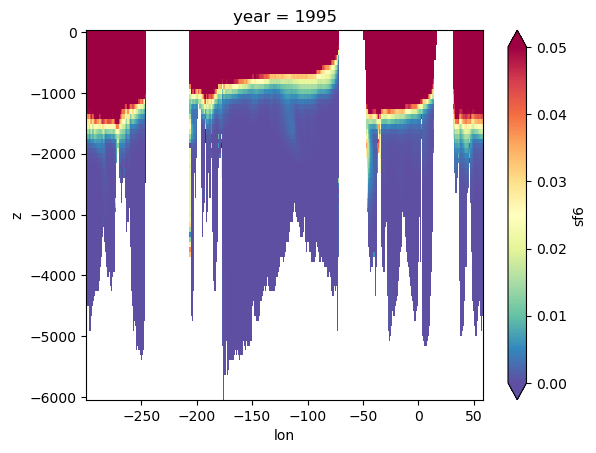

In [66]:
ds_section.isel(year = -20).sf6.plot(vmin = 0, vmax = 0.05, cmap = "Spectral_r")

In [67]:
timeseries = ds_section.sel(lon = slice(-47, -46)).mean("lon")

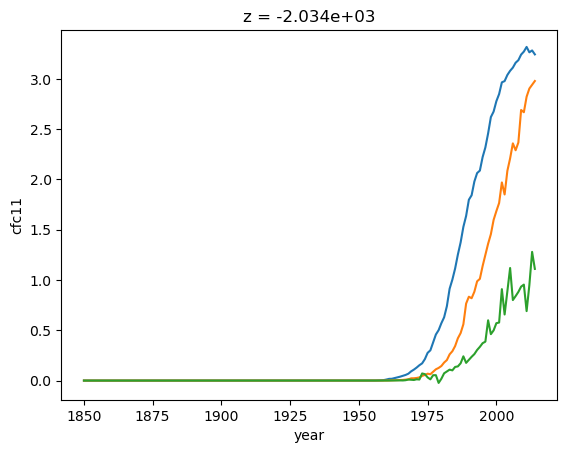

In [69]:

timeseries.cfc11.sel(z = -500, method = "nearest").plot()
timeseries.cfc11.sel(z = -1000, method = "nearest").plot()
timeseries.cfc11.sel(z = -2000, method = "nearest").plot()

## Interpolate GLODAP data to Easy Ocean line
Options to use a 3D interpolator (`RBFInterpolator`; see [here](https://stackoverflow.com/questions/11214118/3d-extrapolation-in-python-basically-scipy-griddata-extended-to-extrapolate) for example) or the `LocStream` functionality in `xesmf.Regridder` (see [here](https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/Comparing_to_section_data.html) for example).

In [186]:
from scipy.interpolate import RBFInterpolator

In [241]:
# Subset only to locations where measurements were made
cond = np.isfinite(dfo['G2cfc12'])
v = dfo[['G2longitude','G2latitude','G2depth']][cond].to_numpy()
d = dfo['G2cfc12'][cond].values

xi, yi, zi = np.meshgrid(dso_nc['longitude'].values,
                         dso_nc['latitude'].values,
                         dso_nc['pressure'].values)
vi = np.vstack((xi.ravel(), yi.ravel(), zi.ravel())).transpose()

rbf = RBFInterpolator(v, d, kernel="thin_plate_spline",smoothing=1000)
di = rbf(vi)

di = di.reshape(xi.shape)
tmp = dso_nc['temperature'].isel(gridded_section=0).squeeze()
dsg = xr.Dataset()
dsg['cfc12'] = tmp.copy(data=di.squeeze().transpose()).where(np.isfinite(tmp))

NameError: name 'dfo' is not defined

## Interpolate model data to Easy Ocean line

In [188]:
dsmo = dsm.interp({'lat':dso_nc['latitude'],'lon':dso_nc['longitude'],'z_l':dso_nc['pressure']}).squeeze()

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


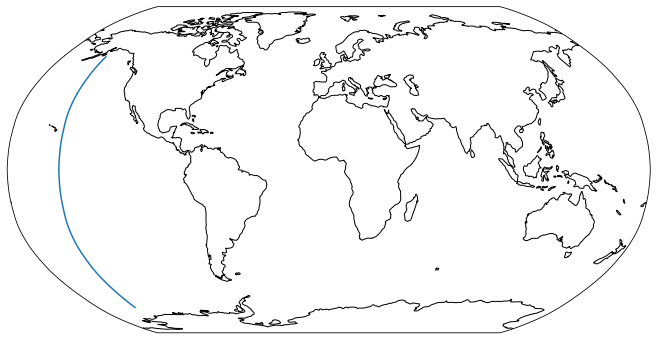

In [189]:
if dimx=='longitude':
    x=dso_nc['longitude'].values
    y=dso_nc['latitude']*xr.ones_like(dso_nc['longitude']).squeeze().values
elif dimx=='latitude':
    x=dso_nc['longitude']*xr.ones_like(dso_nc['latitude']).squeeze().values
    y=dso_nc['latitude'].values
    
fig,ax=plt.subplots(figsize=(12,6),subplot_kw={'projection':ccrs.Robinson()})
ax.set_global()
ax.plot(x,y,transform=ccrs.PlateCarree())
ax.coastlines()

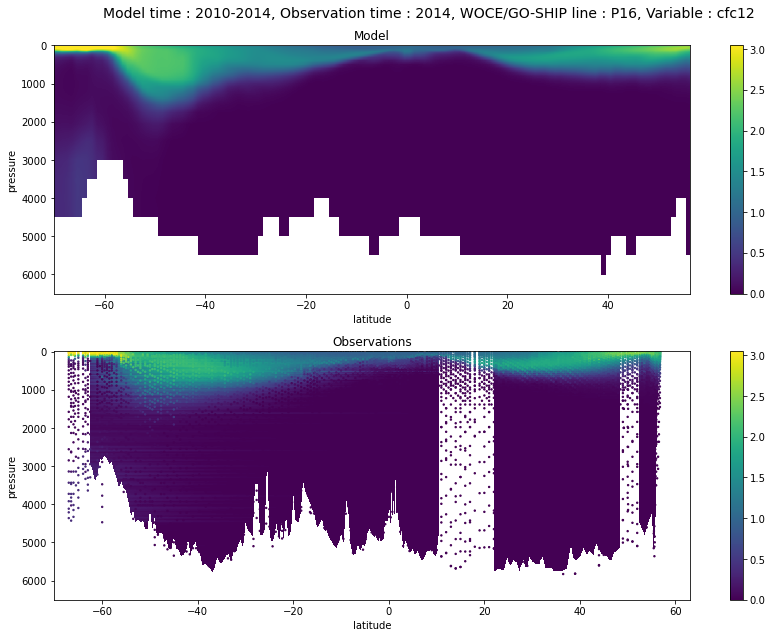

In [196]:
variable = 'cfc12'
conversion = 1e12/1035
x = dsg[dimx]
y = dsg['pressure']
zo = dsg[variable]
zm = dsmo[variable]*conversion

fig,ax = plt.subplots(figsize=(12,9),nrows=2)

fig.suptitle('Model time : '+time+
              ', Observation time : '+str(yearo)+
              ', WOCE/GO-SHIP line : '+line+
              ', Variable : '+variable,
            fontsize=14)

im = ax[0].pcolormesh(x,y,zm,shading='auto')
ax[0].invert_yaxis()
ax[0].set_title('Model')
ax[0].set_xlabel(dimx)
ax[0].set_ylabel('pressure')
plt.colorbar(im,ax=ax[0])

imp = ax[1].pcolormesh(x,y,zo,shading='auto')
ax[1].invert_yaxis()
# Add original observations
ims = ax[1].scatter(v[:,1],v[:,2],c=d,s=2)
clims = list(imp.get_clim())
clims[0]=0
imp.set_clim(clims)
ims.set_clim(clims)
im.set_clim(clims) # Set model lims to obs
ax[1].set_title('Observations')
ax[1].set_xlabel(dimx)
ax[1].set_ylabel('pressure')
plt.colorbar(imp,ax=ax[1])

fig.tight_layout()